In [1]:
import torch
import scipy.io as sio
import numpy as np
import os
import skimage.io
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

**Download model**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget -q -O flatnet_separable_pointGrey_transposeInit https://www.dropbox.com/s/zh8ucresezrfb5o/flatnet_separable_pointGrey_transposeInit?dl=0
!wget -q -O flatnet_separable_pointGrey_randomInit https://www.dropbox.com/s/kve8ki2wll9lytg/flatnet_separable_pointGrey_randomInit?dl=0

**Set the path to the trained model**

In [4]:
# specify the path to the pretrained model.
# modelRoot = r'flatnet_separable_pointGrey_transposeInit' ##Use this for Proposed-T
modelRoot = r'flatnet_separable_pointGrey_randomInit' ##Use this for Proposed-R

In [5]:
from skimage import transform
tform = transform.SimilarityTransform(rotation=0.00174) #to account for small rotation 

In [6]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

    
    
class double_conv2(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3,stride=2, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x    

    
    

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            double_conv2(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3,padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class FlatNet(nn.Module):
    def __init__(self, n_channels=4):
        super(FlatNet, self).__init__()
        self.inc = inconv(n_channels, 128)
        self.down1 = down(128, 256)
        self.down2 = down(256, 512)
        self.down3 = down(512, 1024)
        self.down4 = down(1024, 1024)
        self.up1 = up(2048, 512)
        self.up2 = up(1024, 256)
        self.up3 = up(512, 128)
        self.up4 = up(256, 128)
        self.outc = outconv(128, 3)
        self.PhiL =nn.Parameter(torch.randn(500,256,1)) 
        self.PhiR = nn.Parameter(torch.randn(620,256,1)) 
        self.bn=nn.BatchNorm2d(4,momentum=0.99)
    def forward(self, Xinp):
        
        X0 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,0,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        X11 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,1,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        X12 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,2,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        X2 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,3,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        Xout = torch.cat((X2,X12,X11,X0),3)
        x = Xout.permute(0,3,1,2)
        x = self.bn(x)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)

            
        return torch.sigmoid(x)



**Load the model and update it state dictionary with the trained state dictionary**

In [ ]:
flatnet = FlatNet(4)
flatnet.load_state_dict(torch.load(modelRoot,map_location=torch.device('cpu')))
flatnet.eval()

FlatNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): double_conv2(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
 

**Function to pre-process the measurement and evaluate it**

In [ ]:
def evaluate(X):
    X=X/65535.0
    X_train=np.zeros((1,4,500,620))
    im1=np.zeros((500,620,4))
    im1[:,:,0]=X[0::2, 0::2]#b
    im1[:,:,1]=X[0::2, 1::2]#gb
    im1[:,:,2]=X[1::2, 0::2]#gr
    im1[:,:,3]=X[1::2, 1::2]#r
    im1=transform.warp(im1,tform)
    #im=im1[6:506,10:630,:]      
    rowMeans = im1.mean(axis=1, keepdims=True)
    colMeans = im1.mean(axis=0, keepdims=True)
    allMean = rowMeans.mean()
    im1 = im1 - rowMeans - colMeans + allMean

    X_train[0,:,:,:]=np.swapaxes(np.swapaxes(im1,0,2),1,2)
    X_train=X_train.astype('float32')
    X_val=torch.from_numpy(X_train)
    Xvalout=flatnet(X_val)
    ims=Xvalout.detach().numpy()
    ims=np.swapaxes(np.swapaxes(ims[0,:,:,:],0,2),0,1)
    ims=(ims-np.min(ims))/(np.max(ims)-np.min(ims))
    return ims


**Load the measurement and evaluate it on the trained model**

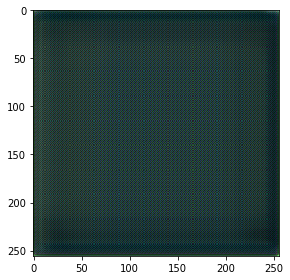

In [ ]:
# Uncomment the below line if using local jupyter server
# !wget -q -O fc_8.png https://raw.githubusercontent.com/siddiquesalman/flatnet/flatnet-sep/example_data/fc_8.png
# Replace the input path with `fc_8.png`

# X = skimage.io.imread("/content/drive/MyDrive/flatnet-flatnet-sep/example_data/fc_8.png") ## Specify the path to the measurement
# print(X.shape)
recn = evaluate(d)
skimage.io.imshow(recn)
    

In [ ]:

a = torch.load(modelRoot,map_location=torch.device('cpu'))

In [ ]:
print(a.keys())

odict_keys(['PhiL', 'PhiR', 'inc.conv.conv.0.weight', 'inc.conv.conv.0.bias', 'inc.conv.conv.1.weight', 'inc.conv.conv.1.bias', 'inc.conv.conv.1.running_mean', 'inc.conv.conv.1.running_var', 'inc.conv.conv.1.num_batches_tracked', 'inc.conv.conv.3.weight', 'inc.conv.conv.3.bias', 'inc.conv.conv.4.weight', 'inc.conv.conv.4.bias', 'inc.conv.conv.4.running_mean', 'inc.conv.conv.4.running_var', 'inc.conv.conv.4.num_batches_tracked', 'down1.mpconv.0.conv.0.weight', 'down1.mpconv.0.conv.0.bias', 'down1.mpconv.0.conv.1.weight', 'down1.mpconv.0.conv.1.bias', 'down1.mpconv.0.conv.1.running_mean', 'down1.mpconv.0.conv.1.running_var', 'down1.mpconv.0.conv.1.num_batches_tracked', 'down1.mpconv.0.conv.3.weight', 'down1.mpconv.0.conv.3.bias', 'down1.mpconv.0.conv.4.weight', 'down1.mpconv.0.conv.4.bias', 'down1.mpconv.0.conv.4.running_mean', 'down1.mpconv.0.conv.4.running_var', 'down1.mpconv.0.conv.4.num_batches_tracked', 'down2.mpconv.0.conv.0.weight', 'down2.mpconv.0.conv.0.bias', 'down2.mpconv.0.co

In [ ]:
print(a['PhiL'].size())

torch.Size([500, 256, 1])


In [ ]:
import numpy as np
import math
from scipy.ndimage import rotate as imrotate
from numpy.linalg import multi_dot


def clean_calib( calib ):
    # Fix any formatting issues from Matlab to Python
    calib['cSize'] = np.squeeze(calib['cSize'])
    calib['angle'] = np.squeeze(calib['angle'])


def obtain_calib_svd( calib ):
    calib_svd = calib # note, what happens to calib_svd happens to calib. To make just a copy, calib_svd = dict(calib)
    clean_calib(calib_svd)
    P1 = np.dstack((calib['P1r'], calib['P1gb'], calib['P1gr'], calib['P1b']))
    Q1 = np.dstack((calib['Q1r'], calib['Q1gb'], calib['Q1gr'], calib['Q1b']))
    # Initialize new entries for calib data struct
    calib_svd['UL_all'] = np.empty([P1.shape[0], P1.shape[0], 4])
    calib_svd['DL_all'] = np.empty([P1.shape[0], P1.shape[1], 4])
    calib_svd['VL_all'] = np.empty([P1.shape[1], P1.shape[1], 4])
    calib_svd['singL_all'] = np.empty([P1.shape[1], 4])
    calib_svd['UR_all'] = np.empty([Q1.shape[0], Q1.shape[0], 4])
    calib_svd['DR_all'] = np.empty([Q1.shape[0], Q1.shape[1], 4])
    calib_svd['VR_all'] = np.empty([Q1.shape[1], Q1.shape[1], 4])
    calib_svd['singR_all'] = np.empty([Q1.shape[1], 4])
    for i in range(4):
        # Left matrices (P1)
        u, s, vh = np.linalg.svd(P1[:, :, i], full_matrices=True)
        calib_svd['UL_all'][:, :, i] = u
        calib_svd['DL_all'][:, :, i] = np.concatenate((np.diag(s), np.zeros([P1.shape[0] - s.size, s.size])))
        calib_svd['VL_all'][:, :, i] = vh.T
        calib_svd['singL_all'][:, i] = s
        # Right matrices (Q1)
        u, s, vh = np.linalg.svd(Q1[:, :, i], full_matrices=True)
        calib_svd['UR_all'][:, :, i] = u
        calib_svd['DR_all'][:, :, i] = np.concatenate((np.diag(s), np.zeros([Q1.shape[0] - s.size, s.size])))
        calib_svd['VR_all'][:, :, i] = vh.T
        calib_svd['singR_all'][:, i] = s


def fc2bayer( im, calib ):
    # split up different color channels
    r = im[1::2, 1::2]
    gb = im[0::2, 1::2]
    gr = im[1::2, 0::2]
    b = im[0::2, 0::2]
    Y = np.dstack([r, gb, gr, b])
    # rotate capture
    Y = imrotate(Y, calib['angle'], reshape=False)
    # crop usable sensor measurements
    csize = calib['cSize']
    start_row = int((Y.shape[0] - csize[0])/2)
    end_row = int(start_row + csize[0]) # omit -1 because Python indexing does not include end index
    start_col = int((Y.shape[1] - csize[1])/2)
    end_col = int(start_col + csize[1])
    Y = Y[start_row:end_row, start_col:end_col, :]
    return Y


def make_separable( Y ):
    rowMeans = Y.mean(axis=1, keepdims=True)
    colMeans = Y.mean(axis=0, keepdims=True)
    allMean = rowMeans.mean()
    Ysep = Y - rowMeans - colMeans + allMean
    return Ysep


def bayer2rgb( X_bayer, normalize=True ):
    X_rgb = np.empty(X_bayer.shape[:-1] + (3,))  # here, + means append to the tuple
    X_rgb[:, :, 0] = X_bayer[:, :, 0]
    X_rgb[:, :, 1] = 0.5 * (X_bayer[:, :, 1] + X_bayer[:, :, 2])
    X_rgb[:, :, 2] = X_bayer[:, :, 3]
    # normalize to be from 0 to 1
    if normalize:
        X_rgb = (X_rgb - X_rgb.min()) / (X_rgb.max() - X_rgb.min())
    return X_rgb


def fcrecon1( cap, calib, lmbd):
    # check if SVDs have been taken
    if not 'UL_all' in calib:
        obtain_calib_svd(calib)
    #Y = fc2bayer( cap, calib ) 
    Y = cap # convert RAW output to Bayer color channels
    Y = make_separable(Y) # let rows and columns have 0-mean
    #print(f'ysep  : {Y.shape}')
    X_bayer = np.empty([calib['VL_all'].shape[0], calib['VR_all'].shape[0], 4])
    for c in range(4):
        UL = calib['UL_all'][:, :, c]
        DL = calib['DL_all'][:, :, c]
        VL = calib['VL_all'][:, :, c]
        singLsq = np.square(calib['singL_all'][:, c])
        UR = calib['UR_all'][:, :, c]
        DR = calib['DR_all'][:, :, c]
        VR = calib['VR_all'][:, :, c]
        singRsq = np.square(calib['singR_all'][:, c])
        Yc = Y[:, :, c]
        inner = multi_dot([DL.T,UL.T,Yc,UR,DR]) / (np.outer(singLsq, singRsq) + np.full(X_bayer.shape[0:1], lmbd))
        X_bayer[:, :, c] = multi_dot([VL, inner, VR.T])
    X_bayer = X_bayer.clip(min=0)  # non-negative constraint: set all negative values to 0
    return bayer2rgb(X_bayer, True)  # bring back to RGB and normalize

In [ ]:
    def interpolate(image,sizes):
        #print(sizes)
        image1 = torch.nn.functional.interpolate(image.unsqueeze(0),size = (sizes,sizes))
        image1 = image1.squeeze(0)
        return image1

    def apply_noise(img):
        nSig = 10
        Y = img
        normY = torch.norm(Y)
        noise = torch.randn(img.size())
        noise = torch.sqrt((normY / nSig) ** 2 / (Y.numel() * torch.var(noise.view(-1)) )) * noise
        img = img + noise 

        return img
    def apply_noise10(img):
        nSig = 10
        Y = img
        normY = torch.norm(Y)
        noise = torch.randn(img.size())
        noise = torch.sqrt((normY / nSig) ** 2 / (Y.numel() * torch.var(noise.view(-1)) )) * noise
        img = img + noise 

        return img      
    
    def apply_noise5(img):
        nSig = 5
        Y = img
        normY = torch.norm(Y)
        noise = torch.randn(img.size())
        noise = torch.sqrt((normY / nSig) ** 2 / (Y.numel() * torch.var(noise.view(-1)) )) * noise
        img = img + noise 

        return img
    
    def apply_noise2(img):
        nSig = 2
        Y = img
        normY = torch.norm(Y)
        noise = torch.randn(img.size())
        noise = torch.sqrt((normY / nSig) ** 2 / (Y.numel() * torch.var(noise.view(-1)) )) * noise
        img = img + noise 

        return img
        # for i  in range(0, img.size()[1]):
        #   Y = img[i, :, :, :]
        #   tempY = Y - torch.min(torch.zeros(1), torch.min(Y.view(-1)))
        #   normY = torch.dist(tempY, torch.zeros(1), p = 2) 
        #   noise = torch.randn(Y.size())
        #   noise = torch.sqrt((normY / nSig) ** 2 / (Y.numel() * torch.var(noise.view(-1)) )) * noise        
        #   img[i, :, :, :] = Y + noise

        #   return img 


    def lensless_simulation(image):
        P1r = calib['P1r']
        P1b = calib['P1b']
        P1gr = calib['P1gr']
        P1gb = calib['P1gb']

        Q1r = calib['Q1r']
        Q1b = calib['Q1b']
        Q1gr = calib['Q1gr']
        Q1gb = calib['Q1gb']

  
        # image = torch.nn.functional.interpolate(image.unsqueeze(0),size = [256,256])
        # image = image.squeeze(0)
        # rd,g,b = image.unbind(0)
        #print(image.shape)
        #print('sairam 1')
        image_resized = interpolate(image,256)
        #print(f'asdsada : {image_resized.shape}')
        rd,g,b = image_resized.unbind(0)
        #print('sairam 2')
        red  = multi_dot([P1r,rd,Q1r.T])
        green_b = multi_dot([P1gb, g, Q1gb.T])
        green_r = multi_dot([P1gr, g, Q1gr.T])
        blue    = multi_dot([P1b, b, Q1b.T])
        #print('sairam 3')
        scene_image_bayer = np.dstack((red,green_b,green_r,blue))
        '''print('1')
        plt.imshow(red)
        print('2')
        plt.imshow(green_b)
        print('3')
        plt.imshow(green_r)
        print('4')
        plt.imshow(blue)'''
        #print('5')
        #print('sairam 4')
        return scene_image_bayer

In [ ]:
from scipy.io import loadmat
#import flatcam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc

# Load data
meas = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/lensless_imaging/sample_capture.png')  # load flatcam measurement
calib = loadmat('/content/drive/MyDrive/Colab Notebooks/lensless_imaging/flatcam_calibdata.mat')  # load calibration data
clean_calib(calib)
print(meas.shape)
# Reconstruct
lmbd = 3e-4  # L2 regularization parameter
#recon = flatcam.fcrecon(meas, calib, lmbd)

# Show images
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(meas, cmap='gray')
# plt.axis('off')
# plt.title('FlatCam measurement')
# plt.subplot(1, 2, 2)
# plt.imshow(recon)
# plt.axis('off')
# plt.title('FlatCam reconstruction')
# plt.show()

(1024, 1280)


In [ ]:
import os
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import pandas.util.testing as tm
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn



from torch.optim.lr_scheduler import StepLR
 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

import random

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import math
from scipy.ndimage import rotate as imrotate
from numpy.linalg import multi_dot
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
from torchvision import datasets
from collections import defaultdict, deque
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import random
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
from argparse import ArgumentParser
import skimage
import matplotlib.pyplot as plt
import sys
import time
import math
import torch.nn.init as init
#from . import functional as F
from skimage.util import random_noise
import pandas as pd
from PIL import Image
from torchvision.transforms import ToTensor

In [ ]:
rafdb = torch.load('/content/drive/MyDrive/FlatCam_Simulated_RAFDB_Dataset.pth')

In [ ]:
print(rafdb.keys())

dict_keys(['x_train_fc', 'x_train_std', 'x_test_fc', 'x_test_std', 'y_train', 'y_test'])


In [ ]:
x = rafdb['x_train_std']

In [ ]:
print(len(x))

12271


In [ ]:
a = x[0]
y = lensless_simulation(transforms.ToTensor()(a))
y = torch.Tensor(y)
y = apply_noise(y)
print(y.shape)
reconst = fcrecon1(y,calib,lmbd)
reconst = torch.Tensor(reconst).permute(2,0,1)
reconst_image = interpolate(reconst,100)

torch.Size([500, 620, 4])


In [ ]:
    csize = calib['cSize']
    start_row = int((y.shape[0] - csize[0])/2)
    end_row = int(start_row + csize[0]) # omit -1 because Python indexing does not include end index
    start_col = int((y.shape[1] - csize[1])/2)
    end_col = int(start_col + csize[1])
    y = y[start_row:end_row, start_col:end_col, :]
    print(f'Y.shape aadasdasd: {y.shape}')

Y.shape aadasdasd: torch.Size([500, 620, 4])


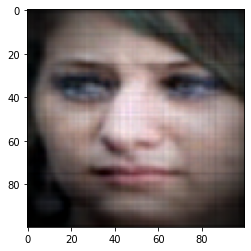

torch.Size([500, 620, 4])


In [ ]:
imshow(reconst_image)
y = make_separable(y)
print(y.shape)

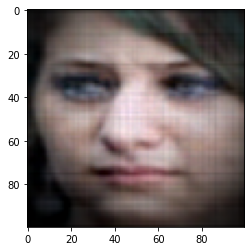

In [ ]:
def imshow(img):
    #mg = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
imshow(reconst_image)

In [ ]:
d = torch.zeros((1000,1240))

In [ ]:
print(d.size())

torch.Size([1024, 1240])


In [ ]:
im1[:,:,0]=X[0::2, 0::2]#b
    im1[:,:,1]=X[0::2, 1::2]#gb
    im1[:,:,2]=X[1::2, 0::2]#gr
    im1[:,:,3]=X[1::2, 1::2]#r

IndentationError: ignored

In [ ]:
y.size()

torch.Size([500, 620, 4])

In [ ]:
d[0::2,0::2] = y[:,:,0]
d[0::2,1::2] = y[:,:,1]
d[1::2,0::2] = y[:,:,2]
d[1::2,1::2] = y[:,:,3]


In [ ]:
imshow(d)

ValueError: ignored

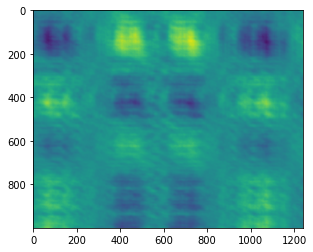

In [ ]:
plt.imshow(d)

torch.Size([1000, 1240])


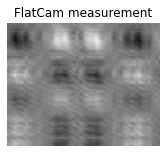

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(d, cmap='gray')
plt.axis('off')
plt.title('FlatCam measurement')
# plt.subplot(1, 2, 2)
# # plt.imshow(recon)
# # plt.axis('off')
# # plt.title('FlatCam reconstruction')
# # plt.show()
print(d.shape)